In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [9]:
data_singles = pd.read_csv("NGC2516_100m_selected_parallax_0.2_pm_inRA_1.5_pm_inDEC_1.5_CMD_cutted_18_CMD_separated_singles.txt", delimiter=';', header=None)
data_singles.rename(columns = {21 : 'BP-RP, mag', 15 : 'G, mag'}, inplace=True)
data_singles = data_singles.apply(pd.to_numeric, errors='coerce')

data_iso = pd.read_csv("NGC2516_isochrone_1.2e8.txt", delimiter=' ')

In [10]:
def to_mf (a, b, c): #get mass of a starS with definite magnitude
    func = interp1d(a, b)
    return func(c)
data_singles['Mass'] = to_mf(data_iso['Gmag']+ 5 * np.log10(410) - 5 + 3.1*0.13*0.86, data_iso['Mass'], data_singles['G, mag'])

In [11]:
Mass_Func = pd.DataFrame(data = {'Mass' : np.linspace(data_singles['Mass'].min(), data_singles['Mass'].max(), 1000)})

In [12]:
kde = KernelDensity( kernel='epanechnikov', bandwidth=0.2).fit(data_singles['Mass'][:, np.newaxis])
Mass_Func['MF_norm'] = np.exp(kde.score_samples(Mass_Func['Mass'][:, np.newaxis]))

Mass_Func['MF'] = Mass_Func['MF_norm'] / Mass_Func['MF_norm'].max()

In [13]:
Mass_Func.to_csv("NGC2516_Mass_function.txt", sep=';', index=False)

Text(0.5,0,'Mass')

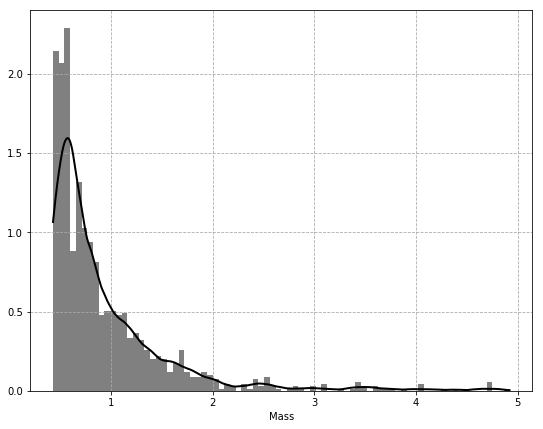

In [8]:
fig, ax = plt.subplots(figsize = (9, 7))
ax.hist(data_singles['Mass'], bins=80, density = True, color = 'gray')

ax.plot(Mass_Func['Mass'], Mass_Func['MF_norm'], c ='black', lw = 2)
ax.grid(c='#aaaaaa', ls='--') 
ax.set_xlabel("Mass")
ax.tick_params(axis='both', which='major', labelsize=15)

In [9]:
Mass_Func = Mass_Func.loc[0.72 < Mass_Func['Mass']]

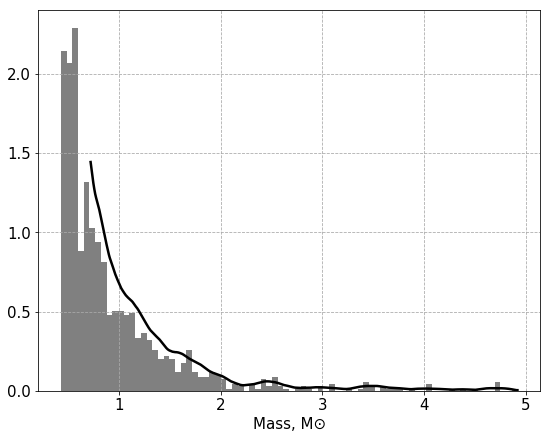

In [22]:
fig, ax = plt.subplots(figsize = (9, 7))
#ax.hist(data_singles['Mass'].loc[0.72 < data_singles['Mass']], bins=80, density = True, color = 'gray')
ax.hist(data_singles['Mass'], bins=80, density = True, color = 'gray')
ax.plot(Mass_Func['Mass'], Mass_Func['MF_norm']*1.3, c ='black', lw = 2.5)
ax.grid(c='#aaaaaa', ls='--') 
ax.set_xlabel("Mass, M\u2299", size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("NGC2516_Mass_function.png")

In [122]:
Mass_Func.to_csv("NGC2516_Mass_function.txt", sep=';', index=False)